In [47]:
import pandas as pd
data = pd.read_csv('preprocessed_data.csv')
data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_10m,weather_group,humidity_change,hour_sin,hour_cos,pressure_trend_6h,month_sin,month_cos,press_std_12h,hum_max_6h,temp_diff_3h
0,24.7,80,21.0,1013.3,96,10.4,Cloudy,4.0,-0.965926,-2.588190e-01,-2.2,0.5,0.866025,1.368808,80.0,-0.5
1,24.2,82,21.0,1013.6,87,6.8,Cloudy,2.0,-1.000000,-1.836970e-16,-1.3,0.5,0.866025,1.395990,82.0,-1.1
2,23.5,87,21.2,1014.1,40,5.3,Cloudy,5.0,-0.965926,2.588190e-01,0.1,0.5,0.866025,1.393383,87.0,-1.6
3,23.4,87,21.0,1015.3,83,5.6,Drizzle,0.0,-0.866025,5.000000e-01,2.1,0.5,0.866025,1.297083,87.0,-1.3
4,23.0,90,21.2,1015.4,86,5.9,Drizzle,3.0,-0.707107,7.071068e-01,2.7,0.5,0.866025,1.161862,90.0,-1.2


In [48]:
data.columns

Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'weather_group',
       'humidity_change', 'hour_sin', 'hour_cos', 'pressure_trend_6h',
       'month_sin', 'month_cos', 'press_std_12h', 'hum_max_6h',
       'temp_diff_3h'],
      dtype='object')

In [49]:
# Tính toán sự thay đổi áp suất và độ ẩm trong 3 giờ gần nhất
# Lưu ý: Thực hiện trên dataframe gốc trước khi đưa vào mô hình
data['pressure_trend_3h'] = data['surface_pressure'].diff(periods=3)
data['humidity_trend_3h'] = data['relative_humidity_2m'].diff(periods=3)

# Điền các giá trị NaN do hàm diff tạo ra
data.dropna(inplace=True)

In [50]:
X = data.drop(columns=['weather_group'])
y = data['weather_group'].astype('category').cat.codes # Chuyển nhãn chữ sang số

In [ ]:
X = data.drop(columns=['weather_group', 'hum_max_6h'])
y = data['weather_group'].astype('category').cat.codes

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, shuffle=False)


In [ ]:
from sklearn.preprocessing import RobustScaler

robust_features = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'surface_pressure', 'wind_speed_10m', 'humidity_change', 
    'pressure_trend_6h', 'press_std_12h', 'temp_diff_3h'
]

robust_scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[robust_features] = robust_scaler.fit_transform(X_train[robust_features])
X_val_scaled[robust_features] = robust_scaler.transform(X_val[robust_features])
X_test_scaled[robust_features] = robust_scaler.transform(X_test[robust_features])

## 4. Softmax Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
from imblearn.pipeline import Pipeline
import time
import numpy as np

### 4.1 Tìm kiếm siêu tham số (Hyperparameter Tuning)

Để tìm ra bộ tham số tối ưu cho mô hình Softmax Regression, chúng tôi sử dụng kỹ thuật **Grid Search** kết hợp với **Time Series Cross Validation**.

**Phương pháp:**
- **Grid Search**: Thử nghiệm exhaustive trên một lưới các giá trị tham số.
- **TimeSeriesSplit**: Vì dữ liệu là chuỗi thời gian, việc chia tập validation cần tôn trọng thứ tự thời gian. `TimeSeriesSplit` chia dữ liệu thành *k* fold liên tiếp, trong đó fold thứ *i* dùng làm train cho fold thứ *i+1* (validation), đảm bảo không dùng tương lai để dự đoán quá khứ.

**Các siêu tham số được tinh chỉnh:**
1.  **C** (Regularization Strength): [0.001, 0.01, 1, 10, 100]
2.  **solver**: ['lbfgs', 'newton-cg']
3.  **max_iter**: 1000


In [ ]:
# Chuẩn bị dữ liệu: Gộp Train và Val để GridSearch với TimeSeriesSplit
X_train_val = pd.concat([X_train_scaled, X_val_scaled])
y_train_val = pd.concat([y_train, y_val])

In [ ]:
# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)

# Thử nghiệm các tổ hợp trọng số
custom_weights = [{0: 1, 1: 1.2, 2: 1.5}, {0: 1, 1: 1.5, 2: 2.0}]

# Tạo pipeline: Poly -> SMOTE -> LogisticRegression
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=3000))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight': [None, 'balanced'] + custom_weights,
    'classifier__solver': ['lbfgs', 'newton-cg'],
    'poly__interaction_only': [False, True]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Thực hiện tìm kiếm
start_search = time.time()
grid_search.fit(X_train_val, y_train_val)
end_search = time.time()

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best validation score: {grid_search.best_score_:.4f}")
print(f"Search time: {end_search - start_search:.2f}s")

best_model_softmax = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time

classifier_l1 = LogisticRegression(
    penalty='l1',           # Sử dụng L1 để triệt tiêu nhiễu
    solver='saga',          # Saga bắt buộc cho L1 + Multinomial
    C=0.01,                 # Ép mô hình đơn giản hơn (giảm từ 1.0 xuống 0.01)
    max_iter=5000,          # L1/Saga cần nhiều vòng lặp để hội tụ hơn
    class_weight={0: 1, 1: 1.5, 2: 3}, # Giữ trọng số ưu tiên lớp Rain
    random_state=42
)

# 1. Tối ưu Pipeline: 
# - Thay SMOTE bằng class_weight trong LogisticRegression (hiệu quả tương đương nhưng nhanh hơn)
# - Thêm StandardScaler SAU khi tạo Poly features (rất quan trọng cho Logistic Regression)
pipeline_fast = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', classifier_l1)
])

custom_weights = [
    'balanced',
    {0: 1, 1: 2, 2: 5},  # Ưu tiên Drizzle gấp 2, Rain gấp 5
    {0: 1, 1: 3, 2: 10}  # Ưu tiên mạnh cho Rain
]

# 2. Thu gọn không gian tham số và dùng RandomizedSearchCV
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1], # Thử các mức siêu nhỏ để chống Overfitting
    'classifier__class_weight': ['balanced', {0: 1, 1: 1.5, 2: 3}]
}

# 3. Sử dụng RandomizedSearchCV thay vì GridSearchCV
# n_iter=10 nghĩa là chỉ thử 10 tổ hợp ngẫu nhiên thay vì 64 tổ hợp
optimized_search = RandomizedSearchCV(
    estimator=pipeline_fast,
    param_distributions=param_dist,
    n_iter=8, 
    cv=tscv,
    scoring='f1_macro', # QUAN TRỌNG: Dùng F1-macro cho dữ liệu không cân bằng thay vì accuracy
    n_jobs=-1,
    verbose=1,
)

# Thực hiện tìm kiếm
start_search = time.time()
optimized_search.fit(X_train_val, y_train_val)
end_search = time.time()

print(f"Best parameters: {optimized_search.best_params_}")
print(f"Best validation score: {optimized_search.best_score_:.4f}")
print(f"Search time: {end_search - start_search:.2f}s")
best_model_softmax = optimized_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Danh\Desktop\DUT_AI\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Danh\Desktop\DUT_AI\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Best parameters: {'classifier__class_weight': {0: 1, 1: 1.5, 2: 3}, 'classifier__C': 0.1}
Best validation score: 0.4871
Search time: 35.70s


In [ ]:
best_clf = optimized_search.fit(X_train_val, y_train_val).best_estimator_.named_steps['classifier']
poly_features = optimized_search.fit(X_train_val, y_train_val).best_estimator_.named_steps['poly'].get_feature_names_out(X.columns)

# Lấy các hệ số khác 0 (đặc trưng quan trọng)
for i, class_name in enumerate(['Cloudy', 'Drizzle', 'Rain']):
    importance = best_clf.coef_[i]
    active_features = [(poly_features[j], importance[j]) for j in range(len(importance)) if abs(importance[j]) > 1e-4]
    print(f"\nSố đặc trưng quan trọng cho lớp {class_name}: {len(active_features)}")
    # In top 3 biến ảnh hưởng nhất
    print(sorted(active_features, key=lambda x: abs(x[1]), reverse=True)[:3])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Danh\Desktop\DUT_AI\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Danh\Desktop\DUT_AI\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Danh\Desktop\DUT_AI\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Danh\Desktop\DUT_AI\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(



Số đặc trưng quan trọng cho lớp Cloudy: 67
[('surface_pressure', np.float64(-1.5390274843110148)), ('relative_humidity_2m cloud_cover', np.float64(-1.059284163812943)), ('hour_cos', np.float64(1.0559584652543863))]

Số đặc trưng quan trọng cho lớp Drizzle: 40
[('dew_point_2m month_cos', np.float64(-0.4307925164273065)), ('cloud_cover temp_diff_3h', np.float64(0.3370487740890992)), ('temperature_2m month_sin', np.float64(-0.3220127928786757))]

Số đặc trưng quan trọng cho lớp Rain: 56
[('relative_humidity_2m', np.float64(1.3862050376084363)), ('temperature_2m relative_humidity_2m', np.float64(-1.3654421790763245)), ('month_sin', np.float64(-1.034677325551425))]


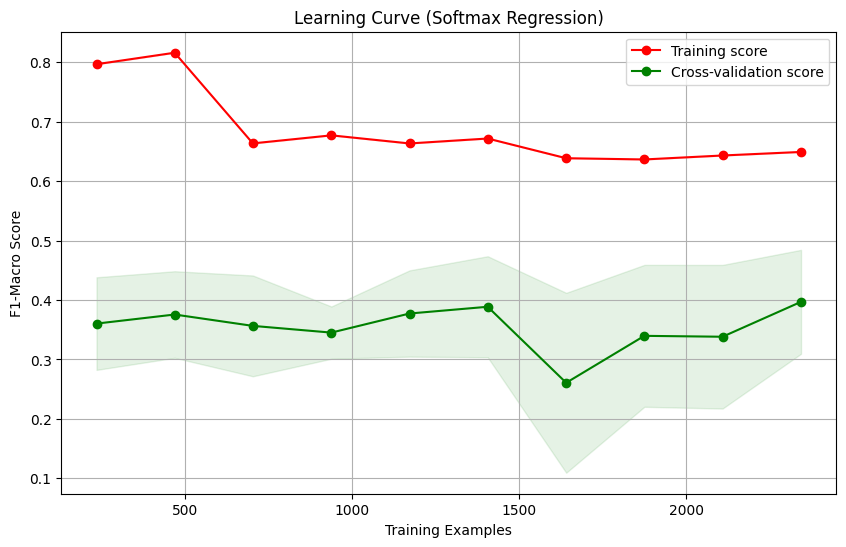

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_macro' # Dùng F1 vì dữ liệu của bạn lệch
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("F1-Macro Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Sử dụng mô hình tốt nhất vừa tìm được
plot_learning_curve(best_model_softmax, X_train_val, y_train_val, tscv, "Learning Curve (Softmax Regression)")

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

# Tạo hàm tự định nghĩa các biến tương tác quan trọng
def custom_features(X):
    X_out = X.copy()
    # Chỉ tạo các biến tương tác mà mô hình đánh giá cao nhất
    X_out['hum_x_cloud'] = X['relative_humidity_2m'] * X['cloud_cover']
    X_out['temp_x_hum'] = X['temperature_2m'] * X['relative_humidity_2m']
    X_out['press_x_month'] = X['surface_pressure'] * X['month_sin']
    return X_out[['hum_x_cloud', 'temp_x_hum', 'press_x_month']]

# Pipeline mới: Gộp biến gốc và biến tương tác thủ công
feature_engineering = FeatureUnion([
    ('original', FunctionTransformer(lambda x: x)), # Giữ nguyên các biến gốc
    ('custom', FunctionTransformer(custom_features)) # Chỉ thêm 3 biến tương tác mạnh
])

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import time

# 1. Định nghĩa Pipeline đơn giản
# Random Forest không bắt buộc phải có Scaler, nhưng giữ lại cũng không sao
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(
        n_estimators=200,       # Số lượng cây (thử từ 100-500)
        max_depth=15,           # Giới hạn độ sâu để tránh overfitting nặng
        min_samples_leaf=5,     # Số mẫu tối thiểu ở mỗi lá để làm mượt mô hình
        class_weight='balanced', # Tự động xử lý dữ liệu không cân bằng
        n_jobs=-1,              # Chạy song song trên toàn bộ CPU
        random_state=42
    ))
])

# 2. Huấn luyện (X_train và y_train nên bao gồm cả các biến Trend đã tạo)
start_time = time.time()
rf_pipeline.fit(X_train, y_train)
end_time = time.time()

print(f"Thời gian huấn luyện: {end_time - start_time:.2f}s")

# 3. Đánh giá trên tập Validation
y_val_pred = rf_pipeline.predict(X_val)
print("\nKết quả trên tập Validation:")
print(classification_report(y_val, y_val_pred))

Thời gian huấn luyện: 1.25s

Kết quả trên tập Validation:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1423
           1       0.50      0.38      0.43       249
           2       0.63      0.51      0.56        83

    accuracy                           0.84      1755
   macro avg       0.67      0.61      0.64      1755
weighted avg       0.83      0.84      0.83      1755



In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, classification_report, accuracy_score
import time

# 1. Khởi tạo danh sách lưu Loss
train_loss_history = []
val_loss_history = []
n_trees_range = range(10, 201, 10)  # Thử từ 10 đến 200 cây, mỗi bước nhảy 10

# 2. Khởi tạo mô hình với warm_start=True
rf = RandomForestClassifier(
    max_depth=15,               # Giới hạn độ sâu để tránh overfitting
    min_samples_leaf=5,         # Ép mô hình học quy luật tổng quát
    class_weight='balanced',    # Xử lý dữ liệu không cân bằng
    warm_start=True,            # Cho phép cộng dồn thêm cây
    n_jobs=-1,
    random_state=42
)

print("Đang huấn luyện và tính toán Loss...")
for n_trees in n_trees_range:
    rf.set_params(n_estimators=n_trees)
    rf.fit(X_train, y_train)
    
    # Dự đoán xác suất để tính Log Loss
    y_train_proba = rf.predict_proba(X_train)
    y_val_proba = rf.predict_proba(X_val)
    
    train_loss_history.append(log_loss(y_train, y_train_proba))
    val_loss_history.append(log_loss(y_val, y_val_proba))

print("Huấn luyện hoàn tất.")

Đang huấn luyện và tính toán Loss...


c:\Users\Danh\Desktop\DUT_AI\venv\Lib\site-packages\sklearn\ensemble\_forest.py:860: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\Danh\Desktop\DUT_AI\venv\Lib\site-packages\sklearn\ensemble\_forest.py:860: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the r

Huấn luyện hoàn tất.



KẾT QUẢ TRÊN TẬP TEST
Accuracy: 0.6872
Inference Time: 0.1050s

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.79      0.71      0.74      1672
     Drizzle       0.61      0.69      0.65      1366
        Rain       0.63      0.61      0.62       472

    accuracy                           0.69      3510
   macro avg       0.68      0.67      0.67      3510
weighted avg       0.70      0.69      0.69      3510



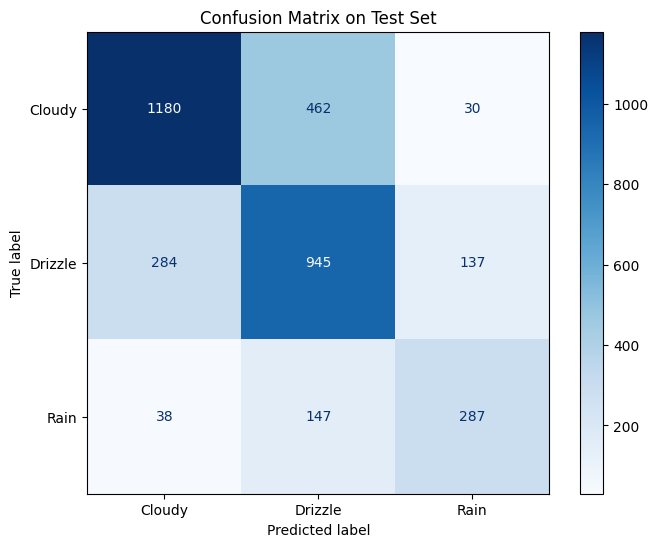

In [72]:
# 3. Dự đoán trên tập Test
start_inf = time.time()
y_test_pred = rf.predict(X_test)
end_inf = time.time()

# 4. In báo cáo kết quả
print("\n" + "="*30)
print("KẾT QUẢ TRÊN TẬP TEST")
print("="*30)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Inference Time: {end_inf - start_inf:.4f}s")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Cloudy', 'Drizzle', 'Rain']))

# In Confusion Matrix cho tập Test
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, 
                                        display_labels=['Cloudy', 'Drizzle', 'Rain'], 
                                        cmap='Blues', ax=ax)
plt.title("Confusion Matrix on Test Set")
plt.show()

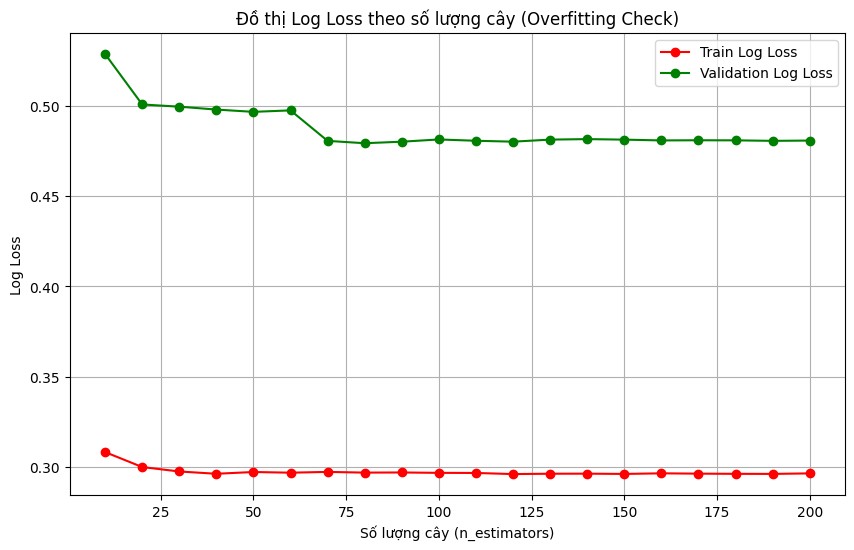

In [73]:
# 5. Vẽ đồ thị Log Loss
plt.figure(figsize=(10, 6))
plt.plot(n_trees_range, train_loss_history, label='Train Log Loss', color='red', marker='o')
plt.plot(n_trees_range, val_loss_history, label='Validation Log Loss', color='green', marker='o')

plt.title('Đồ thị Log Loss theo số lượng cây (Overfitting Check)')
plt.xlabel('Số lượng cây (n_estimators)')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
from sklearn.linear_model import LogisticRegression

# Cấu hình classifier với L1 và C cực nhỏ
classifier_l1 = LogisticRegression(
    penalty='l1',           # Sử dụng L1 để triệt tiêu nhiễu
    solver='saga',          # Saga bắt buộc cho L1 + Multinomial
    multi_class='multinomial',
    C=0.01,                 # Ép mô hình đơn giản hơn (giảm từ 1.0 xuống 0.01)
    max_iter=5000,          # L1/Saga cần nhiều vòng lặp để hội tụ hơn
    class_weight={0: 1, 1: 1.5, 2: 3}, # Giữ trọng số ưu tiên lớp Rain
    random_state=42
)

# Pipeline hoàn chỉnh (Bỏ SMOTE và PolynomialFeatures tự động)
final_pipeline = Pipeline([
    ('eng', feature_engineering),
    ('scaler', StandardScaler()),
    ('classifier', classifier_l1)
])

TypeError: LogisticRegression.__init__() got an unexpected keyword argument 'multi_class'

In [ ]:
# Xem tầm quan trọng của các biến trong Softmax (đã qua Poly)
classifier = best_model_softmax.named_steps['classifier']
poly = best_model_softmax.named_steps['poly']
feature_names = poly.get_feature_names_out(X.columns)

for i, class_label in enumerate(classifier.classes_):
    print(f"\nTop features cho lớp {class_label}:")
    top_indices = np.argsort(np.abs(classifier.coef_[i]))[-5:]
    for idx in top_indices[::-1]:
        print(f"{feature_names[idx]}: {classifier.coef_[i][idx]:.4f}")

KeyError: 'poly'

### 4.2 Kiểm thử mô hình (Model Evaluation)

Sau khi chọn được mô hình tốt nhất, chúng tôi tiến hành đánh giá trên tập kiểm thử (Test Set) hoàn toàn độc lập.

**Các chỉ số đánh giá (Metrics):**
1.  **Accuracy (Độ chính xác)**: Tỷ lệ số mẫu dự đoán đúng trên tổng số mẫu. Đo lường hiệu suất tổng quan.
2.  **Training Time & Inference Time**: 
    - *Training Time*: Thời gian huấn luyện lại mô hình tốt nhất.
    - *Inference Time*: Thời gian mô hình dự đoán trên tập test.
3.  **Precision (Độ chính xác của từng lớp)**: Trong số các mẫu được dự đoán là lớp A, bao nhiêu % thực sự là lớp A. Quan trọng khi muốn giảm thiểu báo động giả (False Positives).
4.  **Recall (Độ phủ)**: Trong số các mẫu thực sự là lớp A, bao nhiêu % được mô hình phát hiện đúng. Quan trọng khi muốn tránh bỏ sót (False Negatives).
5.  **F1-Score**: Trung bình điều hòa của Precision và Recall. Cân bằng giữa độ chính xác và độ phủ, hữu ích khi dữ liệu mất cân bằng.
6.  **Confusion Matrix**: Bảng ma trận hiển thị chi tiết sự nhầm lẫn giữa các lớp.

In [ ]:
# Huấn luyện lại mô hình tốt nhất (hoặc sử dụng kết quả từ GridSearch đã fit trên Train+Val)
# Ở đây GridSearch refit=True mặc định sẽ fit lại trên toàn bộ dữ liệu đưa vào (Train + Val)
# Đo thời gian Inference
start_inf = time.time()
y_pred = best_model_softmax.predict(X_test_scaled)
end_inf = time.time()
inference_time = end_inf - start_inf

# Đánh giá trên Train và Test
train_acc = best_model_softmax.score(X_train_val, y_train_val)
test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy (Result of GridSearch refit): {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Inference Time (on test set): {inference_time:.4f}s")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Training Accuracy (Result of GridSearch refit): 0.7662
Testing Accuracy: 0.6217
Inference Time (on test set): 0.0049s

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.58      0.66      1672
           1       0.54      0.67      0.60      1366
           2       0.54      0.63      0.58       472

    accuracy                           0.62      3510
   macro avg       0.61      0.63      0.61      3510
weighted avg       0.65      0.62      0.63      3510


Confusion Matrix:

[[975 628  69]
 [268 909 189]
 [ 28 146 298]]
